Source: https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb#scrollTo=4nzcagVitLQm

In [3]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
def denorm(img):
    return ((img + train_datagen.mean) / RESCALE).astype(np.uint8)

In [5]:
DATA_PATH = Path("~/data/split-v3-random-nongray").expanduser() 

In [6]:
IMAGE_SIZE = 336

BATCH_SIZE = 90
RESCALE = 1/128

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=RESCALE, 
    featurewise_center=True,
    width_shift_range=.025,
    height_shift_range=.025,
    brightness_range=(.8, 1.2),
    zoom_range=.025,
)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH / "train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=RESCALE,
    featurewise_center=True
)

val_generator = val_datagen.flow_from_directory(
    DATA_PATH / "valid",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 7651 images belonging to 2 classes.
Found 3280 images belonging to 2 classes.


### Fit to calculate featurewise_center:

In [7]:
sample_size = 30
sample_paths = np.random.choice(list((DATA_PATH / "train").glob("*/*.jpeg")), size=sample_size)

imgs = []
for img_path in sample_paths:
    imgs.append(plt.imread(img_path))
imgs = np.stack(imgs)
print(imgs.shape)
train_datagen.fit(imgs)
val_datagen.fit(imgs)

(30, 980, 800, 3)


In [6]:
print(train_datagen.mean)

[[[0.74136317 0.73086095 0.74473   ]]]


In [7]:
image_batch, label_batch = next(train_generator)
image_batch.shape, label_batch.shape

((90, 336, 336, 3), (90, 2))

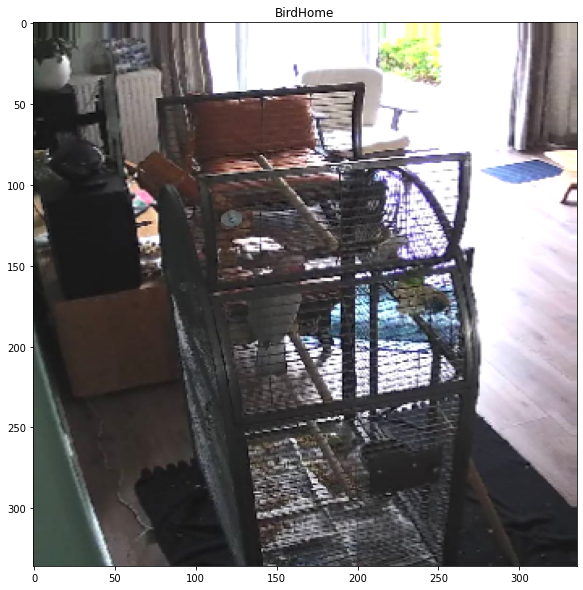

In [8]:
plt.figure(figsize=(10, 10))
idx = 16

plt.title("BirdHome" if label_batch[idx][0] == 1 else "BirdRoaming")
plt.imshow(denorm(image_batch[idx, :]))

In [9]:
print(train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

{'BirdHome': 0, 'BirdRoaming': 1}


In [9]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), 
                 input_shape=IMG_SHAPE))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(.5))

model.add(tf.keras.layers.Dense(32)) 
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 334, 334, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 334, 334, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 334, 334, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 167, 167, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 165, 165, 32)      18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 165, 165, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 165, 165, 32)     

In [13]:
save_dir = Path("~/models/model-from-scratch-dropout-earlier/").expanduser()
save_dir.mkdir(exist_ok=True)
save_ckpt = tf.keras.callbacks.ModelCheckpoint(
    str((save_dir / "model.{epoch:02d}-{val_loss:.2f}.hdf5")), 
    verbose=1
)

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

In [16]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[save_ckpt, early_stop]
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 86 steps, validate for 37 steps
Epoch 1/30
85/86 [============================>.] - ETA: 3s - loss: 0.5158 - accuracy: 0.7510
Epoch 00001: saving model to /home/jvlier/models/model-from-scratch-dropout-earlier/model.01-1.23.hdf5
86/86 [==============================] - 368s 4s/step - loss: 0.5148 - accuracy: 0.7511 - val_loss: 1.2328 - val_accuracy: 0.7518
Epoch 2/30
85/86 [============================>.] - ETA: 3s - loss: 0.3858 - accuracy: 0.8208
Epoch 00002: saving model to /home/jvlier/models/model-from-scratch-dropout-earlier/model.02-0.48.hdf5
86/86 [==============================] - 348s 4s/step - loss: 0.3866 - accuracy: 0.8200 - val_loss: 0.4758 - val_accuracy: 0.7982
Epoch 3/30
85/86 [============================>.] - ETA: 3s - loss: 0.3267 - accuracy: 0.8535
Epoch 00003: saving model to /home/jvlier/models/model-from-scratch-dropout-earlier/model.03-0.31.hdf5
86/86 [==============================] - 348s 4s/step - l

### Baseline accuracies

Always predict BirdHome:

- Train: 0.76
- CV: 0.73

In [17]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.grid()
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.ylabel('Cross Entropy')
#     plt.ylim([0,1.0])
    plt.grid()
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

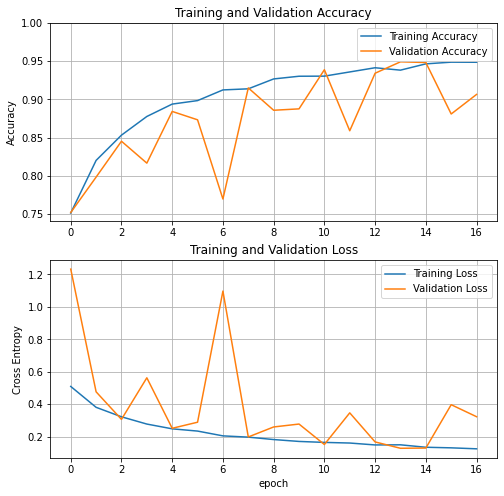

In [18]:
plot_history(history)

Drop LR:

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[save_ckpt, early_stop],
                    initial_epoch=history.epoch[-1] + 1
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 86 steps, validate for 37 steps
Epoch 18/20
85/86 [============================>.] - ETA: 3s - loss: 0.1009 - accuracy: 0.9591
Epoch 00018: saving model to /home/jvlier/models/model-from-scratch-dropout-earlier/model.18-0.11.hdf5
86/86 [==============================] - 355s 4s/step - loss: 0.1008 - accuracy: 0.9594 - val_loss: 0.1144 - val_accuracy: 0.9537
Epoch 19/20
85/86 [============================>.] - ETA: 3s - loss: 0.0969 - accuracy: 0.9630
Epoch 00019: saving model to /home/jvlier/models/model-from-scratch-dropout-earlier/model.19-0.10.hdf5
86/86 [==============================] - 355s 4s/step - loss: 0.0965 - accuracy: 0.9630 - val_loss: 0.1006 - val_accuracy: 0.9582
Epoch 20/20
85/86 [============================>.] - ETA: 3s - loss: 0.0940 - accuracy: 0.9673
Epoch 00020: saving model to /home/jvlier/models/model-from-scratch-dropout-earlier/model.20-0.10.hdf5
86/86 [==============================] - 355s 4s/step 

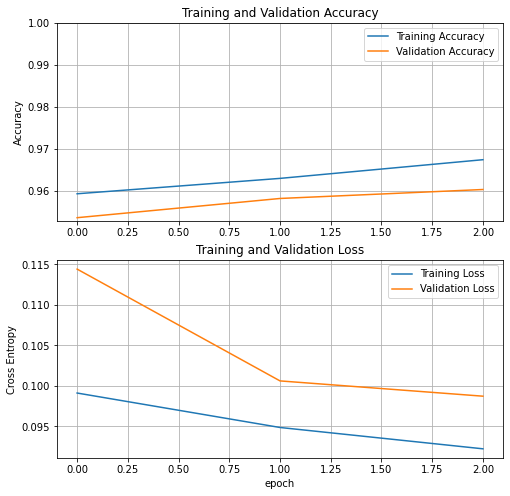

In [28]:
plot_history(history)

Oops, I should've upped the # of epochs. Let's keep on going for a bit with the same LR:

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=40,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[save_ckpt, early_stop],
                    initial_epoch=20
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 86 steps, validate for 37 steps
Epoch 21/40
85/86 [============================>.] - ETA: 3s - loss: 0.0882 - accuracy: 0.9671
Epoch 00021: saving model to /home/jvlier/models/model-from-scratch-dropout-earlier/model.21-0.09.hdf5
86/86 [==============================] - 355s 4s/step - loss: 0.0880 - accuracy: 0.9672 - val_loss: 0.0893 - val_accuracy: 0.9671
Epoch 22/40
85/86 [============================>.] - ETA: 3s - loss: 0.0897 - accuracy: 0.9661
Epoch 00022: saving model to /home/jvlier/models/model-from-scratch-dropout-earlier/model.22-0.11.hdf5
86/86 [==============================] - 354s 4s/step - loss: 0.0894 - accuracy: 0.9660 - val_loss: 0.1148 - val_accuracy: 0.9521
Epoch 23/40
85/86 [============================>.] - ETA: 3s - loss: 0.0845 - accuracy: 0.9706
Epoch 00023: saving model to /home/jvlier/models/model-from-scratch-dropout-earlier/model.23-0.09.hdf5
86/86 [==============================] - 353s 4s/step 

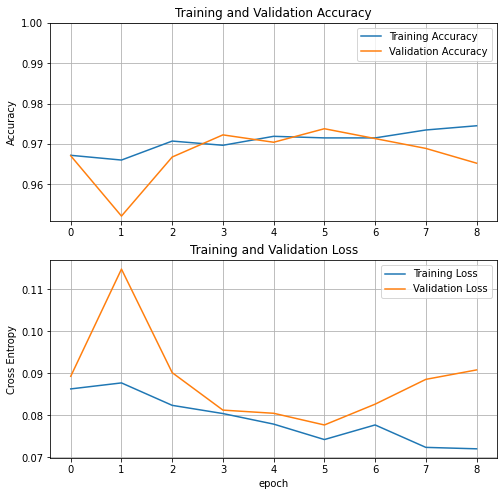

In [34]:
plot_history(history)

Deploying model at epoch 26 to Pi!

In [21]:
list(save_dir.glob("model.26*"))

[PosixPath('/home/jvlier/models/model-from-scratch-dropout-earlier/model.26-0.08.hdf5')]

In [24]:
lm = tf.keras.models.load_model

In [26]:
model = lm("/home/jvlier/models/model-from-scratch-dropout-earlier/model.26-0.08.hdf5")

In [27]:
model.save("/home/jvlier/models/model-from-scratch-dropout-earlier/export")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/jvlier/models/model-from-scratch-dropout-earlier/export/assets


In [34]:
x = np.ones((336, 336, 3))

In [35]:
x - train_datagen.mean

array([[[0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        ...,
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ]],

       [[0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        ...,
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ]],

       [[0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        ...,
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ]],

       ...,

       [[0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0.22833139, 0.2092551 ],
        [0.21905917, 0

In [39]:
train_datagen.mean

array([[[0.78094083, 0.7716686 , 0.7907449 ]]], dtype=float32)

In [48]:
imgs.shape

(30, 980, 800, 3)

In [52]:
imgs[:, :, :, 1].mean()

105.10606356292517

In [53]:
imgs[:, :, :, 2].mean()

108.02197988945578

In [54]:
(imgs[:, :, :, 0] * (1/128)).mean()

0.8281604083625638

In [51]:
((imgs[:, :, :, 0]  * (1/128)).mean()

0.822059308128156

In [60]:
res = (imgs * RESCALE) - train_datagen.mean

In [62]:
res[:, :, :, 1].mean()

0.04947250862835216

In [63]:
res = (x * RESCALE) - train_datagen.mean

In [65]:
res.shape

(336, 336, 3)

In [67]:
res.reshape((1, 336, 336, 3))

array([[[[-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ],
         ...,
         [-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ]],

        [[-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ],
         ...,
         [-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ]],

        [[-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ],
         ...,
         [-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ],
         [-0.77312833, -0.76385611, -0.7829324 ]],

        ...,

        [[-0.77312833, -0.76385611, -0